In [1]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.quantum_info import *
import numpy as np
from scipy.linalg import *
from sympy import *

from functools import reduce

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal as aae

Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')
Duplicate key in file '/Users/minhpham/.matplotlib/matplotlibrc', line 3 ('backend: TkAgg')


In [2]:
tensor = lambda matrix_list: reduce(np.kron, matrix_list)

In [4]:
def one_qubit_partial_trace(rho: np.ndarray, traced_qubit: int) -> DensityMatrix:

    dim = int(np.log2(len(rho)))
    assert traced_qubit < dim, "Traced qubit index out of range"
    
    I = np.identity(2)
    zero = np.array([[1], [0]])
    one = np.array([[0], [1]])

    # Create pre and post of partial trace
    pre_zero = tensor([zero.T if i == traced_qubit else I for i in range(dim)])
    post_zero = tensor([zero if i == traced_qubit else I for i in range(dim)])
    pre_one = tensor([one.T if i == traced_qubit else I for i in range(dim)])
    post_one = tensor([one if i == traced_qubit else I for i in range(dim)])

    reduced_density_matrix = DensityMatrix(pre_zero@rho@post_zero + pre_one@rho@post_one)
    
    assert reduced_density_matrix.is_valid(), 'Reduced density operator is not valid'

    return reduced_density_matrix

def is_pure_state(rho: DensityMatrix):
    if np.isclose(np.abs(rho.purity()), 1): 
        print("Pure State")
        return rho.to_statevector().data
    else:
        print("Mixed State")
        return None

### Two-Qubit State

We know that the canonical form for any two qubit states is 

$$|\psi\rangle = \cos(\theta)|00\rangle + \sin(\theta)|11\rangle$$

This gives us the density matrix (abbreviating cosines and sines)

$$\rho_{AB} = |\psi\rangle\langle\psi| = c^2|00\rangle\langle 00|+ cs |00\rangle \langle 11| + cs |11\rangle\langle00| + s^2 |11\rangle\langle11|$$

Taking the partial trace of the subsytem $B$, we get

$$\begin{align}\rho_A = Tr_B [\rho_{AB}] &= (I\otimes \langle0|)\rho_{AB}(I\otimes |0\rangle) + (I\otimes \langle1|)\rho_{AB}(I\otimes |1\rangle) \\ &= c^2|00\rangle\langle00| + s^2|11\rangle\langle11|\end{align}$$

This gives us an expression for purity

$$\begin{align}Tr[\rho_A^2] &= \cos^4(\theta) + \sin^4(\theta) \\ &= \frac{1}{4} \cos(4\theta) + \frac{3}{4}\end{align}$$

Up to local unitary, we have

$$|\psi'\rangle = \cos(\theta)|\alpha\beta\rangle + \sin(\theta)|\alpha_{\perp} \beta_{\perp}\rangle $$

Recall that the partial trace and purity calculation is independent of subsystem basis. So now, since our state $|\psi\rangle$ and $|\psi'\rangle$ are equivalent up to local unitary, it should have the same partial trace and purity.

Our canonical form is parameterized by an angle $\theta$ and has a period of $2\pi$. Our purity expression on the other hand, has a period of $\frac{\pi}{2}$. One would think that $|\psi(\theta)\rangle \stackrel{LU}{\equiv}|\psi(\theta')\rangle$ would implies $\theta = \theta'$. This is true in certain cases, for example, $\theta' = \theta + \frac{\pi n}{2}$. This is related to the fact that a Pauli $Y$ can commute through a CX gate into Pauli $Z$ and Pauli $X$. However, when $\theta' = -\theta + \frac{\pi n}{2}$, the equivalence relation does not hold. For each purity value, there are up to 8 possibles angle values on the interval of $[-\pi, \pi]$.

Text(0, 0.5, 'Purity')

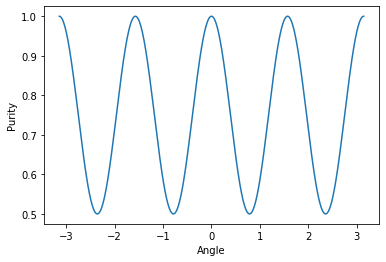

In [5]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 1000):

    circ = QuantumCircuit(2)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(2), 0)
    circ.unitary(random_unitary(2), 1)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 0

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()
    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 1000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

### Three Qubit

We will concern ourselves with Class 2 and Class 3 states. We can check that our states are in these two classes by taking 3 partial trace of subsystems $A, B, C$ and verifying that the corresponding reduced density matrix represents a mixed state.

#### Class 2

We will first look at the Class 2 states to analyze their entanglement structure. Below we show a representative circuit.

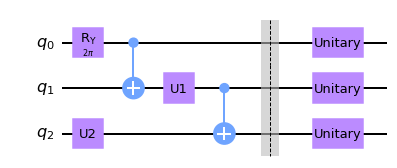

In [6]:
circ = QuantumCircuit(3)
circ.ry(2*theta, 0)
circ.cx(0, 1)
circ.unitary(random_unitary(dims = 2, seed = 1), 1, label = 'U1')
circ.unitary(random_unitary(dims = 2, seed = 2), 2, label = 'U2')
circ.cx(1, 2)

circ.barrier()
circ.unitary(random_unitary(dims = 2, seed = 0), 0)
circ.unitary(random_unitary(dims = 2, seed = 3), 1)
circ.unitary(random_unitary(dims = 2, seed = 4), 2)

circ.draw('mpl')

In fact, when we take the partial trace of a subsystem, we can ignore the layer of local unitary. We first start with tracing out qubit 0

Text(0, 0.5, 'Purity')

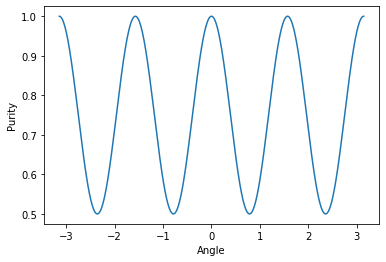

In [7]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 1000):

    circ = QuantumCircuit(3)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000)), 1)
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000)), 2)
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 0

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 1000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

We see that the purity graph still depends on the angle of $\theta$ as the two qubit case. Variations in the parameters of $U1$ and $U2$ does not affect the purity.

Text(0, 0.5, 'Purity')

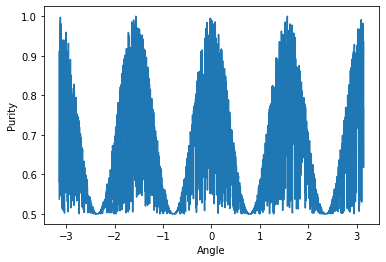

In [8]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 2000):

    circ = QuantumCircuit(3)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000) ), 1) # U1
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000)), 2) # U2
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 1

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 2000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

The graph still has the original periodic structure that depends on $\theta$ that is it retains the period and range. However, now the amplitude of the function depends on the parameters of $U1$ and $U2$. (Investigate this!)

Text(0, 0.5, 'Purity')

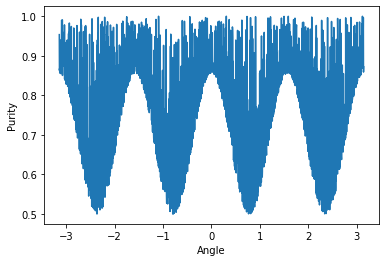

In [9]:
mu_list = []

for theta in np.linspace(-np.pi, np.pi, 2000):

    circ = QuantumCircuit(3)
    circ.ry(2*theta, 0)
    circ.cx(0, 1)
    circ.unitary(random_unitary(dims = 2, seed = 2 ), 1) # U1
    circ.unitary(random_unitary(dims = 2, seed = np.random.randint(0, 1000) ), 2) # U2
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 2

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 2000), mu_list)
plt.xlabel('Angle')
plt.ylabel('Purity')

When both parameters of $U1$ and $U2$ are randomized. The graph lost all it sinusoidal characteristic. However, it still retains the range of the angle. Interestingly, when the parameter of $U1$ are free to range, the graph fills the bottom of the curve. On the other hand, when the parameters of $U2$ are randomized. The graph fills the top fo the curve.

To investigate the parameterization of $Tr_B[\rho]$ and $Tr_C[\rho]$, we decompose U1 into $Rz$ and $Ry$ (the other $Rz$ commute through the control) and we decompose U2 into $Ry$ and $Rz$ (the other $Rz$ turns into a global phase when the input of $q_2$ is $|0\rangle$).

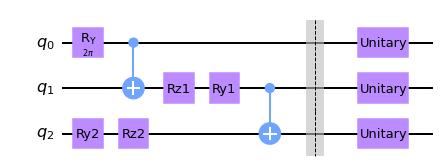

In [10]:
circ = QuantumCircuit(3)
circ.ry(2*theta, 0)
circ.cx(0, 1)
circ.unitary(random_unitary(dims = 2, seed = 1), 1, label = 'Rz1')
circ.unitary(random_unitary(dims = 2, seed = 1), 1, label = 'Ry1')
circ.unitary(random_unitary(dims = 2, seed = 2), 2, label = 'Ry2')
circ.unitary(random_unitary(dims = 2, seed = 2), 2, label = 'Rz2')
circ.cx(1, 2)

circ.barrier()
circ.unitary(random_unitary(dims = 2, seed = 0), 0)
circ.unitary(random_unitary(dims = 2, seed = 3), 1)
circ.unitary(random_unitary(dims = 2, seed = 4), 2)

circ.draw('mpl')

In [11]:
theta_ry0
theta_rz1
theta_ry1
theta_rz2
theta_ry2

NameError: name 'theta_ry0' is not defined

Text(0, 0.5, 'Purity')

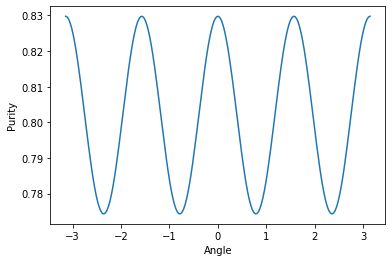

In [12]:
mu_list = []

np.random.seed(0)

theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

for epsilon2 in np.linspace(-np.pi, np.pi, 200):

    circ = QuantumCircuit(3)
    circ.ry(2*theta0, 0)
    circ.cx(0, 1)
    
    circ.rz(2*epsilon1, 1) # Rz1
    circ.ry(2*theta1, 1) # Ry1

    circ.ry(2*theta2, 2) # Ry2
    circ.rz(2*epsilon2, 2) # Rz2
    
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 1

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 200), mu_list)

plt.xlabel('Angle')
plt.ylabel('Purity')

Text(0, 0.5, 'Purity')

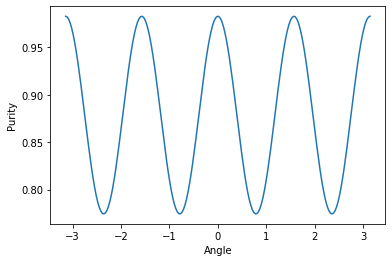

In [13]:
mu_list = []

np.random.seed(0)

theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

for epsilon2 in np.linspace(-np.pi, np.pi, 200):

    circ = QuantumCircuit(3)
    circ.ry(2*theta0, 0)
    circ.cx(0, 1)
    
    circ.rz(2*epsilon1, 1) # Rz1
    circ.ry(2*theta1, 1) # Ry1

    circ.ry(2*theta2, 2) # Ry2
    circ.rz(2*epsilon2, 2) # Rz2
    
    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 2

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu = dm.purity()

    mu_list.append(mu)

plt.plot(np.linspace(-np.pi, np.pi, 200), mu_list)

plt.xlabel('Angle')
plt.ylabel('Purity')

The behaviour of the paramters when tracing out qubit 1 and qubit 2 is the same

- $\theta_0$ varies $\implies \rho$ is sinusoidal
- $\theta_1$ varies $\implies \rho$ is sinusoidal
- $\theta_2$ varies $\implies \rho$ is flipped-sinusoidal
- $\epsilon_1$ varies $\implies \rho$ is constant
- $\epsilon_2$ varies $\implies \rho$ is sinusoidal

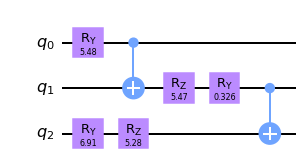

In [14]:
np.random.seed(2)

theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

circ = QuantumCircuit(3)

circ.ry(2*theta0, 0)

circ.cx(0, 1)

circ.ry(2*theta2, 2) # Ry2
circ.rz(2*epsilon2, 2) # Rz2

circ.rz(2*epsilon1, 1) # Rz1
circ.ry(2*theta1, 1) # Ry1

circ.cx(1, 2)

circ.draw('mpl')

We will start looking at the properties above algebraically. First, we reconstruct the state $|\psi\rangle$ in terms of the parameters

In [424]:
from sympy.physics.quantum import TensorProduct as tp
CX = Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
Ry = lambda theta: Matrix([[cos(theta/2), -sin(theta/2)], [sin(theta/2), cos(theta/2)]])
Rz = lambda theta: Matrix([[exp(I*-theta/2), 0], [0, exp(I*theta/2)]])
ID = Matrix([[1, 0], [0, 1]])

In [425]:
t = [symbols(f'theta_{i}') for i in range(3)]
e = [symbols(f'epsilon_{i}') for i in range(3)]

ket_psi = (tp(ID, CX)@tp(ID, Ry(t[1]*2)@Rz(e[1]*2), ID)@tp(CX, ID)@tp(Ry(t[0]*2), ID, Rz(e[2]*2)@Ry(t[2]*2)))[:, 0]

In [426]:
ket_psi

Matrix([
[exp(-I*epsilon_1)*exp(-I*epsilon_2)*cos(theta_0)*cos(theta_1)*cos(theta_2)],
[ exp(-I*epsilon_1)*exp(I*epsilon_2)*sin(theta_2)*cos(theta_0)*cos(theta_1)],
[ exp(-I*epsilon_1)*exp(I*epsilon_2)*sin(theta_1)*sin(theta_2)*cos(theta_0)],
[exp(-I*epsilon_1)*exp(-I*epsilon_2)*sin(theta_1)*cos(theta_0)*cos(theta_2)],
[-exp(I*epsilon_1)*exp(-I*epsilon_2)*sin(theta_0)*sin(theta_1)*cos(theta_2)],
[ -exp(I*epsilon_1)*exp(I*epsilon_2)*sin(theta_0)*sin(theta_1)*sin(theta_2)],
[  exp(I*epsilon_1)*exp(I*epsilon_2)*sin(theta_0)*sin(theta_2)*cos(theta_1)],
[ exp(I*epsilon_1)*exp(-I*epsilon_2)*sin(theta_0)*cos(theta_1)*cos(theta_2)]])

In [427]:
# Test for correctness
psi_actual = Statevector(circ.reverse_bits()).data.reshape(8, 1)
psi_test = simplify(ket_psi.subs([(t[0], theta0), 
          (t[1], theta1), 
          (t[2], theta2), 
          (e[1], epsilon1), 
          (e[2], epsilon2)]))

psi_test = np.array(psi_test).astype(np.complex128)

aae(psi_actual, psi_test)

Now we construct the density matrix

In [428]:
bra_psi = Matrix([[exp(-I*-e[1])*exp(-I*-e[2])*cos(t[0])*cos(t[1])*cos(t[2]),exp(-I*-e[1])*exp(I*-e[2])*sin(t[2])*cos(t[0])*cos(t[1]),exp(-I*-e[1])*exp(I*-e[2])*sin(t[1])*sin(t[2])*cos(t[0]),exp(-I*-e[1])*exp(-I*-e[2])*sin(t[1])*cos(t[0])*cos(t[2]),-exp(I*-e[1])*exp(-I*-e[2])*sin(t[0])*sin(t[1])*cos(t[2]),-exp(I*-e[1])*exp(I*-e[2])*sin(t[0])*sin(t[1])*sin(t[2]),exp(I*-e[1])*exp(I*-e[2])*sin(t[0])*sin(t[2])*cos(t[1]),exp(I*-e[1])*exp(-I*-e[2])*sin(t[0])*cos(t[1])*cos(t[2])]])

rho = ket_psi@bra_psi

# We verify that the trace is equal to 1
simplify(simplify(Trace(rho)))

1

We now look at the partial trace. We will rebuild the partial trace function from above

In [419]:
def one_qubit_partial_trace_sym(rho: Matrix, traced_qubit: int) -> Matrix:

    dim = int(np.log2(rho.shape[0]))
    assert traced_qubit < dim, "Traced qubit index out of range"
    
    ID = Matrix([[1, 0], [0, 1]])
    zero = Matrix([[1], [0]])
    one = Matrix([[0], [1]])

    # Create pre and post of partial trace
    pre_zero = tp(*[zero.T if i == traced_qubit else ID for i in range(dim)])
    post_zero = tp(*[zero if i == traced_qubit else ID for i in range(dim)])
    pre_one = tp(*[one.T if i == traced_qubit else ID for i in range(dim)])
    post_one = tp(*[one if i == traced_qubit else ID for i in range(dim)])

    reduced_density_matrix = pre_zero@rho@post_zero + pre_one@rho@post_one

    assert simplify(simplify(Trace(reduced_density_matrix))) == 1, 'Reduced density operator is not valid'
    return reduced_density_matrix

In [420]:
trace_sym = lambda rho: simplify(simplify(Trace(rho@rho))) # Symbolic trace

#### 1. Subsystem $\rho_{BC}$

In [22]:
rho_0 = one_qubit_partial_trace_sym(rho, 0)

purity0 = trace_sym(rho_0)

purity0

2*sin(theta_0)**4 - 2*sin(theta_0)**2 + 1

We have an expression for the purity of the mixed state of combined subsystem $BC$. Interestingly, it only depends on one parameter $\theta_0$. In addition, the expression below is exactly the same as that the traced subsystem of the 2 qubit case.

$$\begin{align} Tr[\rho_{BC}^2] &= 2\sin^4(\theta_0) - 2\sin^2(\theta_0) + 1 \\ &= \sin^4(\theta_0) + \sin^4(\theta_0) - 2\sin^2(\theta_0) + 1 \\ &= \sin^4(\theta_0) + (1-\sin^2(\theta_0))^2 \\ &= \sin^4(\theta_0) + \cos^4(\theta_0) \\ &= \frac{3}{4}\cos(4\theta_0) + \frac{1}{4}\end{align}$$

#### 2. Subsystem $\rho_{AC}$

In [24]:
rho_1 = one_qubit_partial_trace_sym(rho, 1)

purity1 = simplify(trace_sym(rho_1))

purity1

2*exp(4*I*epsilon_2)*sin(theta_0)**4*sin(theta_1)**2*sin(theta_2)**2*cos(theta_1)**2*cos(theta_2)**2 - 4*exp(4*I*epsilon_2)*sin(theta_0)**2*sin(theta_1)**2*sin(theta_2)**2*cos(theta_0)**2*cos(theta_1)**2*cos(theta_2)**2 + 2*exp(4*I*epsilon_2)*sin(theta_1)**2*sin(theta_2)**2*cos(theta_0)**4*cos(theta_1)**2*cos(theta_2)**2 - sin(theta_0)**4*sin(theta_1)**4*cos(4*theta_2)/4 + sin(theta_0)**4*sin(theta_1)**4/4 - sin(theta_0)**4*cos(theta_1)**4*cos(4*theta_2)/4 + sin(theta_0)**4*cos(theta_1)**4/4 + sin(theta_0)**4*cos(2*theta_1 - 2*theta_2)**2/8 + sin(theta_0)**4*cos(2*theta_1 - 2*theta_2)*cos(2*theta_1 + 2*theta_2)/4 + sin(theta_0)**4*cos(2*theta_1 + 2*theta_2)**2/8 + sin(theta_0)**4/2 + 8*sin(theta_0)**2*sin(theta_1)**2*sin(theta_2)**2*cos(theta_0)**2*cos(theta_1)**2*cos(theta_2)**2 + 4*sin(theta_0)**2*sin(theta_1)**2*cos(theta_0)**2*cos(theta_1)**2*cos(2*theta_2)**2 - sin(theta_1)**4*cos(theta_0)**4*cos(4*theta_2)/4 + sin(theta_1)**4*cos(theta_0)**4/4 - cos(theta_0)**4*cos(theta_1)**4*co

If we separate the real and the complex part of this expression and simplify them individually, and after that add them together, we get a real expression. This is because the value for purity is real. If we look at all the parameters in the expression, we will see that $\epsilon_1$ is missing. The confirms our observation that $\epsilon_1$ remains constant from above.

In [25]:
purity1.free_symbols

{epsilon_2, theta_0, theta_1, theta_2}

In [26]:
terms = purity1.args

for i, term in enumerate(terms):
    print(i, term, '\n')

0 cos(theta_0)**4/2 

1 sin(theta_0)**4/2 

2 cos(theta_0)**4*cos(theta_1)**4/4 

3 sin(theta_1)**4*cos(theta_0)**4/4 

4 sin(theta_0)**4*cos(theta_1)**4/4 

5 sin(theta_0)**4*sin(theta_1)**4/4 

6 cos(theta_0)**4*cos(2*theta_1 - 2*theta_2)**2/8 

7 cos(theta_0)**4*cos(2*theta_1 + 2*theta_2)**2/8 

8 sin(theta_0)**4*cos(2*theta_1 - 2*theta_2)**2/8 

9 sin(theta_0)**4*cos(2*theta_1 + 2*theta_2)**2/8 

10 -cos(theta_0)**4*cos(theta_1)**4*cos(4*theta_2)/4 

11 -sin(theta_1)**4*cos(theta_0)**4*cos(4*theta_2)/4 

12 -sin(theta_0)**4*cos(theta_1)**4*cos(4*theta_2)/4 

13 -sin(theta_0)**4*sin(theta_1)**4*cos(4*theta_2)/4 

14 cos(theta_0)**4*cos(2*theta_1 - 2*theta_2)*cos(2*theta_1 + 2*theta_2)/4 

15 sin(theta_0)**4*cos(2*theta_1 - 2*theta_2)*cos(2*theta_1 + 2*theta_2)/4 

16 4*sin(theta_0)**2*sin(theta_1)**2*cos(theta_0)**2*cos(theta_1)**2*cos(2*theta_2)**2 

17 2*exp(-4*I*epsilon_2)*sin(theta_1)**2*sin(theta_2)**2*cos(theta_0)**4*cos(theta_1)**2*cos(theta_2)**2 

18 2*exp(4*I*epsilon_2)*si

In [27]:
real_terms = sum(terms[:17] + (terms[21], ))
real_terms = simplify(simplify(real_terms))

complex_terms = sum(terms[17:21] + terms[22:])
complex_terms = simplify(simplify(complex_terms))

In [28]:
purity1 = expand(real_terms + complex_terms)

In [ ]:
# Testing expression

for i in range(100):
    np.random.seed(i)

    theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

    circ = QuantumCircuit(3)
    circ.ry(2*theta0, 0)
    circ.cx(0, 1)

    circ.rz(2*epsilon1, 1) # Rz1
    circ.ry(2*theta1, 1) # Ry1

    circ.ry(2*theta2, 2) # Ry2
    circ.rz(2*epsilon2, 2) # Rz2

    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 1

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu_actual = dm.purity()

    mu_test = simplify(final_purity1.subs([(t[0], theta0), 
              (t[1], theta1), 
              (t[2], theta2), 
              (e[1], epsilon1), 
              (e[2], epsilon2)]))

    aae(float(mu_test), mu_actual)

In [29]:
terms = expand(expand_trig(purity1)).args

terms

(1,
 -2*sin(theta_0)**2,
 -2*sin(theta_1)**2,
 2*sin(theta_0)**4,
 2*sin(theta_1)**4,
 -8*sin(theta_0)**2*sin(theta_1)**4,
 -8*sin(theta_0)**4*sin(theta_1)**2,
 -4*sin(theta_1)**2*sin(theta_2)**4,
 -4*sin(theta_1)**4*sin(theta_2)**2,
 4*sin(theta_1)**2*sin(theta_2)**2,
 4*sin(theta_1)**4*sin(theta_2)**4,
 8*sin(theta_0)**2*sin(theta_1)**2,
 8*sin(theta_0)**4*sin(theta_1)**4,
 -16*sin(theta_0)**2*sin(theta_1)**2*sin(theta_2)**2,
 -16*sin(theta_0)**2*sin(theta_1)**4*sin(theta_2)**4,
 -16*sin(theta_0)**4*sin(theta_1)**2*sin(theta_2)**4,
 -16*sin(theta_0)**4*sin(theta_1)**4*sin(theta_2)**2,
 16*sin(theta_0)**2*sin(theta_1)**2*sin(theta_2)**4,
 16*sin(theta_0)**2*sin(theta_1)**4*sin(theta_2)**2,
 16*sin(theta_0)**4*sin(theta_1)**2*sin(theta_2)**2,
 16*sin(theta_0)**4*sin(theta_1)**4*sin(theta_2)**4,
 4*sin(theta_1)**2*sin(theta_2)**2*cos(theta_1)**2*cos(theta_2)**2,
 -32*sin(theta_1)**2*sin(theta_2)**2*cos(epsilon_2)**2*cos(theta_1)**2*cos(theta_2)**2,
 -16*sin(theta_1)**2*sin(theta_2)**2*c

Looking at the terms of our expression, we see that we have:

Real Terms
- 1 terms of coefficient 1, each has 0 trig terms
- 4 terms with coefficient ±2, each has 1 trig terms
- 4 terms with coefficient ±4, each has 2 trig terms
- 4 terms with coefficient ±8, each has 2 trig terms
- 8 terms with coefficient ±16, each has 3 trig terms

Imaginary Terms
- 1 terms with coefficient 4, each has 4 trig terms
- 2 terms with coefficient ±16, each has 5 trig terms
- 2 terms with coefficient ±32, each has 5 trig terms
- 4 terms with coefficient ±128, each has 6 trig terms

In [231]:
from sympy.simplify.fu import *

In [285]:
expr_theta0 = collect(expand(TR6(expand(TR11(purity1)))), sin(t[0])).args

for elem in expr_theta0:
    display(elem)

sin_2_theta0 = expr_theta0[3]
sin_4_theta0 = expr_theta0[4]

constant_theta0 = sum(expr_theta0[:3] + expr_theta0[5:])

1

-2*sin(theta_1)**2

2*sin(theta_1)**4

(-128*sin(epsilon_2)**4*sin(theta_1)**4*sin(theta_2)**4 + 128*sin(epsilon_2)**4*sin(theta_1)**4*sin(theta_2)**2 + 128*sin(epsilon_2)**4*sin(theta_1)**2*sin(theta_2)**4 - 128*sin(epsilon_2)**4*sin(theta_1)**2*sin(theta_2)**2 + 128*sin(epsilon_2)**2*sin(theta_1)**4*sin(theta_2)**4 - 128*sin(epsilon_2)**2*sin(theta_1)**4*sin(theta_2)**2 - 128*sin(epsilon_2)**2*sin(theta_1)**2*sin(theta_2)**4 + 128*sin(epsilon_2)**2*sin(theta_1)**2*sin(theta_2)**2 - 32*sin(theta_1)**4*sin(theta_2)**4 + 32*sin(theta_1)**4*sin(theta_2)**2 - 8*sin(theta_1)**4 + 32*sin(theta_1)**2*sin(theta_2)**4 - 32*sin(theta_1)**2*sin(theta_2)**2 + 8*sin(theta_1)**2 - 2)*sin(theta_0)**2

(128*sin(epsilon_2)**4*sin(theta_1)**4*sin(theta_2)**4 - 128*sin(epsilon_2)**4*sin(theta_1)**4*sin(theta_2)**2 - 128*sin(epsilon_2)**4*sin(theta_1)**2*sin(theta_2)**4 + 128*sin(epsilon_2)**4*sin(theta_1)**2*sin(theta_2)**2 - 128*sin(epsilon_2)**2*sin(theta_1)**4*sin(theta_2)**4 + 128*sin(epsilon_2)**2*sin(theta_1)**4*sin(theta_2)**2 + 128*sin(epsilon_2)**2*sin(theta_1)**2*sin(theta_2)**4 - 128*sin(epsilon_2)**2*sin(theta_1)**2*sin(theta_2)**2 + 32*sin(theta_1)**4*sin(theta_2)**4 - 32*sin(theta_1)**4*sin(theta_2)**2 + 8*sin(theta_1)**4 - 32*sin(theta_1)**2*sin(theta_2)**4 + 32*sin(theta_1)**2*sin(theta_2)**2 - 8*sin(theta_1)**2 + 2)*sin(theta_0)**4

-8*sin(theta_1)**2*sin(theta_2)**4

-8*sin(theta_1)**4*sin(theta_2)**2

8*sin(theta_1)**2*sin(theta_2)**2

8*sin(theta_1)**4*sin(theta_2)**4

-32*sin(epsilon_2)**2*sin(theta_1)**2*sin(theta_2)**2

-32*sin(epsilon_2)**2*sin(theta_1)**4*sin(theta_2)**4

-32*sin(epsilon_2)**4*sin(theta_1)**2*sin(theta_2)**4

-32*sin(epsilon_2)**4*sin(theta_1)**4*sin(theta_2)**2

32*sin(epsilon_2)**2*sin(theta_1)**2*sin(theta_2)**4

32*sin(epsilon_2)**2*sin(theta_1)**4*sin(theta_2)**2

32*sin(epsilon_2)**4*sin(theta_1)**2*sin(theta_2)**2

32*sin(epsilon_2)**4*sin(theta_1)**4*sin(theta_2)**4

In [287]:
coef_list = []
constant_list = []

for i in range(100):
    np.random.seed(i)

    theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

    coef_2_theta0 = sin_2_theta0.subs([(t[0], theta0), 
              (t[1], theta1), 
              (t[2], theta2), 
              (e[1], epsilon1), 
              (e[2], epsilon2)])/sin(theta0)**2

    coef_4_theta0 = sin_4_theta0.subs([(t[0], theta0), 
              (t[1], theta1), 
              (t[2], theta2), 
              (e[1], epsilon1), 
              (e[2], epsilon2)])/sin(theta0)**4

    constant_val = constant_theta0.subs([(t[0], theta0), 
              (t[1], theta1), 
              (t[2], theta2), 
              (e[1], epsilon1), 
              (e[2], epsilon2)])
    
    coef_list.append(coef_4_theta0)
    constant_list.append(constant_val)

    aae(coef_2_theta0, -coef_4_theta0)
    assert coef_4_theta0 >= 0, 'Coef 4 not positive'
    assert constant_val>= 0, 'Constant not positive'

In [288]:
min(coef_list)

0.0253684585318783

In [289]:
max(coef_list)

1.99889050015722

In [290]:
min(constant_list)

0.506342114632970

In [291]:
max(constant_list)

0.999722625039304

In [312]:
alpha0 = sin_4_theta0 / sin(t[0])**4
beta0 = constant_theta0

simplify((alpha0 - 2) / (beta0 - 1))

4

We can write the purity in terms of the variable $\sin(\theta_0)$ as

$$\begin{align}\mu(\theta_0) &= \alpha_0 sin^4(\theta_0) - \alpha_0 sin^2(\theta_0) + \beta_0 \\ &= \alpha_0 \sin^2(\theta_0) (\sin^2(\theta_0) - 1) + \beta_0 \\ &= -\alpha_0 (\sin(\theta_0)\cos(\theta_0)^2 + \beta_0 \\ &= -\frac{\alpha_0}{4} \sin^2(2\theta_0) + \beta_0 \end{align}$$



where,

- $0 \leq \alpha_0 \leq 2$
- $\frac{1}{2} \leq \beta_0 \leq 1$

The coefficients $\alpha_0$ and $\beta_0$ satisty the relationship

$$\frac{\alpha_0 - 2}{\beta_0-1} = 4$$

This relationship assures that $0.5 \leq \mu \leq 1$, as mixed state should.

Rearranging and substituing into our purity expression, we have

$$\begin{align}\mu(\theta_0) &= -\frac{a_0}{4}\sin^2(2\theta_0) + \frac{\alpha_0+2}{4} \\  &= \frac{1}{2} + \frac{\alpha_0}{4} \cos^2(\theta_0) \end{align}$$

In [403]:
expr_theta1 = collect(alpha0, sin(t[1])).args

constant_theta1 = expr_theta1[0]
sin_2_theta1 = expr_theta1[1]
sin_4_theta1 = expr_theta1[2]

alpha1 = sin_4_theta1 / sin(t[1])**4

We can further expand the coefficients $\alpha_0$ into its component series.

$$\alpha_0 = \alpha_1 \sin^4(\theta_1) - \alpha_1 \sin^2(\theta_1) + 2$$

where $0 \leq \alpha_1 \leq 8$

In [394]:
expr_theta2 = collect(alpha1, sin(t[2])).args

constant_theta2 = expr_theta2[0]
sin_2_theta2 = expr_theta2[1]
sin_4_theta2 = expr_theta2[2]

alpha2 = sin_4_theta2/ sin(t[2])**4

Similarly, we can write $\alpha_1$ as series of $\theta_2$ and $\epsilon_2$

$$\alpha_1 = \alpha_2\sin^4(\theta_2) - \alpha_2 \sin^2(\theta_2) + 8$$

where $0 \leq \alpha_2 \leq 32$

And finally, we decompose $\alpha_2$

$$\alpha_2 = 128 \sin^4(\epsilon_2) - 128 \sin^2(\epsilon_2) + 32$$

To summarize

#### Purity Expression

$$\mu(\theta_0) =  \alpha_0 \sin^4(\theta_0) - \alpha_0 \sin^2(\theta_0) + \frac{1}{2} + \frac{\alpha_0}{4}$$

#### Coefficients Expression

$$\alpha_0 = \alpha_1 \sin^4(\theta_1) - \alpha_1 \sin^2(\theta_1) + 2$$

$$\alpha_1 = \alpha_2\sin^4(\theta_2) - \alpha_2 \sin^2(\theta_2) + 8$$

$$\alpha_2 = 128 \sin^4(\epsilon_2) - 128 \sin^2(\epsilon_2) + 32$$

In [417]:
for i in range(10_000):

    theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

    circ = QuantumCircuit(3)
    circ.ry(2*theta0, 0)
    circ.cx(0, 1)

    circ.rz(2*epsilon1, 1) # Rz1
    circ.ry(2*theta1, 1) # Ry1

    circ.ry(2*theta2, 2) # Ry2
    circ.rz(2*epsilon2, 2) # Rz2

    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 1

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu_actual = dm.purity()

    alpha2 = 128*np.sin(epsilon2)**4 - 128*np.sin(epsilon2)**2 + 32
    alpha1 = alpha2*np.sin(theta2)**4 - alpha2*np.sin(theta2)**2 + 8
    alpha0 = alpha1*np.sin(theta1)**4 - alpha1*np.sin(theta1)**2 + 2
    mu_test = alpha0*np.sin(theta0)**4 - alpha0*np.sin(theta0)**2 + 1/2 + alpha0/4

    aae(mu_actual, mu_test)

#### 3. Subsystem $\rho_{AB}$

In [472]:
rho_2 = one_qubit_partial_trace_sym(rho, 2)

purity2 = simplify(trace_sym(rho_2))

purity2

sin(theta_0)**4*sin(theta_1)**4 + 8*sin(theta_0)**4*sin(theta_1)**2*sin(theta_2)**2*cos(2*epsilon_2)**2*cos(theta_1)**2*cos(theta_2)**2 + sin(theta_0)**4*cos(theta_1)**4 + 8*sin(theta_0)**2*sin(theta_1)**4*sin(theta_2)**2*cos(2*epsilon_2)**2*cos(theta_0)**2*cos(theta_2)**2 + 4*sin(theta_0)**2*sin(theta_1)**2*cos(theta_0)**2*cos(theta_1)**2 + 8*sin(theta_0)**2*sin(theta_2)**2*cos(2*epsilon_2)**2*cos(theta_0)**2*cos(theta_1)**4*cos(theta_2)**2 + sin(theta_1)**4*cos(theta_0)**4 + 8*sin(theta_1)**2*sin(theta_2)**2*cos(2*epsilon_2)**2*cos(theta_0)**4*cos(theta_1)**2*cos(theta_2)**2 + cos(theta_0)**4*cos(theta_1)**4

In [476]:
purity2.free_symbols

{epsilon_2, theta_0, theta_1, theta_2}

If we look at all the parameters in the expression, we will see that $\epsilon_1$ is missing. The confirms our observation that $\epsilon_1$ remains constant from above.

Looking at the expression, we see that we have:
- 4 terms with coefficient 1, each has 2 terms
- 1 terms with coefficient 4, each has 4 terms
- 4 terms with coefficient 8, each has 5 terms
- 8 terms with coefficient ±32, each has 6 terms

First, we rewrite everything in terms of sine terms

In [542]:
expr_theta0 = collect(expand(TR6(expand(TR11(purity2)))), sin(t[0])).args

In [547]:
sin_2_theta0 = expr_theta0[3]
sin_4_theta0 = expr_theta0[4]

alpha0 = sin_4_theta0/sin(t[0])**4

beta0 = sum(expr_theta0[:3] + expr_theta0[5:])

Factor the $\sin(\theta_0)$ out of the series, we get the purity expression

$$\mu = \alpha_0\sin^4(\theta_0) - \alpha_0\sin^2(\theta_0) + \beta_0$$

We now further factor $\sin(\theta_1)$ from $\alpha_0$ and $\beta_0$

In [585]:
expr_theta10 = collect(alpha0, sin(t[1])).args

sin_2_theta10 = expr_theta10[3]
sin_4_theta10 = expr_theta10[4]

alpha1 = sin_4_theta10 / sin(t[1])**4
gamma1 = sum(expr_theta10[:3] + expr_theta10[5:])

expr_theta11 = collect(beta0, sin(t[1])).args

sin_2_theta11 = expr_theta11[1]
sin_4_theta11 = expr_theta11[2]

beta1 = sin_4_theta11 / sin(t[1])**4
beta1_contant = expr_theta11[0]

We now have the expressions,

$$\alpha_0 = \alpha_1\sin^4(\theta_1) - \alpha_1\sin^2(\theta_1) + \gamma_1$$

$$\beta_0 = \beta_1 \sin^4(\theta_1) - \beta_1\sin^2(\theta_1) + 1$$

It turns our that $\gamma_1 = \beta_1$, so we can reduce the expression to 

$$\alpha_0 = \alpha_1\sin^4(\theta_1) - \alpha_1\sin^2(\theta_1) + \beta_1$$

$$\beta_0 = \beta_1 \sin^4(\theta_1) - \beta_1\sin^2(\theta_1) + 1$$

Rinse and repeat, now we factor out $\sin(\theta_2)$

In [586]:
expr_theta20 = collect(alpha1, sin(t[2])).args

sin_2_theta20 = expr_theta20[1]
sin_4_theta20 = expr_theta20[2]
gamma2 = expr_theta20[0]

alpha2 = sin_4_theta20 / sin(t[2])**4

In [590]:
gamma2

8

$$\alpha_1 = \alpha_2\sin^4(\theta_2) - \alpha_2\sin^2(\theta_2) + 8$$

In [601]:
expr_theta21 = collect(beta1, sin(t[2])).args

beta2_contant = expr_theta21[0]
sin_2_theta21 = expr_theta21[1]
sin_4_theta21 = expr_theta21[2]

beta2 = sin_4_theta21 / sin(t[2])**4

In [602]:
expr_theta21

(2,
 (-32*sin(epsilon_2)**4 + 32*sin(epsilon_2)**2 - 8)*sin(theta_2)**2,
 (32*sin(epsilon_2)**4 - 32*sin(epsilon_2)**2 + 8)*sin(theta_2)**4)

$$\beta_1 = \beta_2\sin^4(\theta_2) - \beta_2\sin^2(\theta_2) + 2$$

And for the last time

In [603]:
expr_epsilon20 = collect(alpha2, sin(e[2])).args

$$\alpha_2 = 128\sin^4(\epsilon_2) - 128\sin^2(\epsilon_2) + 32$$

In [604]:
expr_epsilon21 = collect(beta2, sin(e[2])).args
expr_epsilon21

(8, -32*sin(epsilon_2)**2, 32*sin(epsilon_2)**4)

$$\beta_2 = 32\sin^4(\epsilon_2) - 32\sin^2(\epsilon_2) + 8$$

So finally, we gather allt he expression together, this time from the bottom up

$$\beta_2 = 32\sin^4(\epsilon_2) - 32\sin^2(\epsilon_2) + 8$$
$$\alpha_2 = 128\sin^4(\epsilon_2) - 128\sin^2(\epsilon_2) + 32$$

$$\beta_1 = \beta_2\sin^4(\theta_2) - \beta_2\sin^2(\theta_2) + 2$$
$$\alpha_1 = \alpha_2\sin^4(\theta_2) - \alpha_2\sin^2(\theta_2) + 8$$

$$\beta_0 = \beta_1 \sin^4(\theta_1) - \beta_1\sin^2(\theta_1) + 1$$
$$\alpha_0 = \alpha_1\sin^4(\theta_1) - \alpha_1\sin^2(\theta_1) + \beta_1$$

$$\mu = \alpha_0\sin^4(\theta_0) - \alpha_0\sin^2(\theta_0) + \beta_0$$

From the first two expression, we can see that $\alpha_2 = 4\beta_2$. Substitute that into the expression for $\beta_1$, we again get $\alpha_1 = 4\beta_1$, and after this, we can't reduce anymore. So we have the final list of expression

$$\mu = \alpha_0\sin^4(\theta_0) - \alpha_0\sin^2(\theta_0) + \beta_0$$

$$\alpha_0 = 4\beta_1\sin^4(\theta_1) - 4\beta_1\sin^2(\theta_1) + \beta_1$$

$$\beta_0 = \beta_1 \sin^4(\theta_1) - \beta_1\sin^2(\theta_1) + 1$$
$$\beta_1 = \beta_2\sin^4(\theta_2) - \beta_2\sin^2(\theta_2) + 2$$
$$\beta_2 = 32\sin^4(\epsilon_2) - 32\sin^2(\epsilon_2) + 8$$





In [606]:
for i in range(10_000):

    theta0, theta1, theta2, epsilon1, epsilon2 = np.random.uniform(0, 2*np.pi, 5)

    circ = QuantumCircuit(3)
    circ.ry(2*theta0, 0)
    circ.cx(0, 1)

    circ.rz(2*epsilon1, 1) # Rz1
    circ.ry(2*theta1, 1) # Ry1

    circ.ry(2*theta2, 2) # Ry2
    circ.rz(2*epsilon2, 2) # Rz2

    circ.cx(1, 2)

    rho = DensityMatrix(circ.reverse_bits()).data
    traced_qubit = 2

    dm = one_qubit_partial_trace(rho, traced_qubit)

    mu_actual = dm.purity()

    beta2 = 32*np.sin(epsilon2)**4 - 32*np.sin(epsilon2)**2 + 8
    beta1 = beta2*np.sin(theta2)**4 - beta2*np.sin(theta2)**2 + 2
    beta0 = beta1*np.sin(theta1)**4 - beta1*np.sin(theta1)**2 + 1
    alpha0 = 4*beta1*np.sin(theta1)**4 - 4*beta1*np.sin(theta1)**2 + beta1
    mu_test = alpha0*np.sin(theta0)**4 - alpha0*np.sin(theta0)**2 + beta0

    aae(mu_actual, mu_test)

#### 1. $Tr[\rho_{BC}^2]$

$$Tr[\rho_{BC}^2] = 2\sin^4(\theta_0) - 2\sin^2(\theta_0) + 1$$

#### 2. $Tr[\rho_{AC}^2]$

$$Tr[\rho_{AC}^2] =  \alpha_0 \sin^4(\theta_0) - \alpha_0 \sin^2(\theta_0) + \frac{1}{2} + \frac{\alpha_0}{4}$$

$$\alpha_0 = \alpha_1 \sin^4(\theta_1) - \alpha_1 \sin^2(\theta_1) + 2$$

$$\alpha_1 = \alpha_2\sin^4(\theta_2) - \alpha_2 \sin^2(\theta_2) + 8$$

$$\alpha_2 = 128 \sin^4(\epsilon_2) - 128 \sin^2(\epsilon_2) + 32$$

#### 3. $Tr[\rho_{AB}^2]$

$$Tr[\rho_{AB}^2] = \alpha_0\sin^4(\theta_0) - \alpha_0\sin^2(\theta_0) + \beta_0$$

$$\alpha_0 = 4\beta_1\sin^4(\theta_1) - 4\beta_1\sin^2(\theta_1) + \beta_1$$

$$\beta_0 = \beta_1 \sin^4(\theta_1) - \beta_1\sin^2(\theta_1) + 1$$

$$\beta_1 = \beta_2\sin^4(\theta_2) - \beta_2\sin^2(\theta_2) + 2$$

$$\beta_2 = 32\sin^4(\epsilon_2) - 32\sin^2(\epsilon_2) + 8$$